# 0 - Load all the Necessary Modules

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# 1 - Load and Process the Data

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

*   For images, packages such as Pillow, OpenCV are useful
*   For audio, packages such as scipy and librosa
*   For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Using [torchvision](https://pytorch.org/vision/stable/index.html), it’s extremely easy to load CIFAR10. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].





In [2]:
from torchvision import datasets, transforms

# Define transformations on the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

#Load the training data
trainset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#Load the test data
testset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data/
Files already downloaded and verified


Let us show some of the training images, for fun.

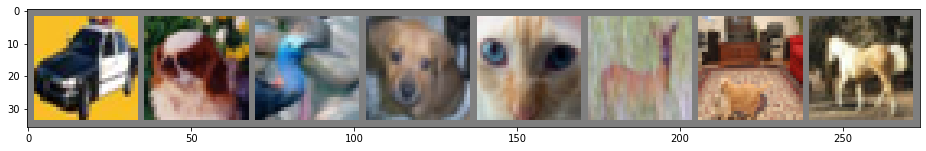

car   dog   bird  dog   cat   deer  cat   horse


In [3]:
import matplotlib.pyplot as plt
from torchvision import utils

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2 - The Model of the Neural Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
model


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's take a look at the summary of our ConvNet.

In [5]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from torchsummary import summary
summary(model, (3, 32, 32), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [8, 6, 28, 28]             456
         MaxPool2d-2             [8, 6, 14, 14]               0
            Conv2d-3            [8, 16, 10, 10]           2,416
         MaxPool2d-4              [8, 16, 5, 5]               0
            Linear-5                   [8, 120]          48,120
            Linear-6                    [8, 84]          10,164
            Linear-7                    [8, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.49
Params size (MB): 0.24
Estimated Total Size (MB): 0.82
----------------------------------------------------------------


# 3 - Train the Model

In [7]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

epochs = 5
print_every = 1000
steps = 0
for e in range(epochs):
  running_loss = 0
  for images, labels in iter(trainloader):
    steps += 1

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if steps % print_every == 0:
      # Make sure network is in eval mode for inference
      model.eval()
      
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
          test_loss, accuracy = validation(model, testloader, criterion)
          
      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss/print_every),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
      
      running_loss = 0
      
      # Make sure training is back on
      model.train()






Epoch: 1/5..  Training Loss: 2.301..  Test Loss: 2.295..  Test Accuracy: 0.103
Epoch: 1/5..  Training Loss: 2.275..  Test Loss: 2.230..  Test Accuracy: 0.149
Epoch: 1/5..  Training Loss: 2.166..  Test Loss: 2.092..  Test Accuracy: 0.233
Epoch: 1/5..  Training Loss: 2.039..  Test Loss: 1.954..  Test Accuracy: 0.285
Epoch: 1/5..  Training Loss: 1.923..  Test Loss: 1.841..  Test Accuracy: 0.317
Epoch: 1/5..  Training Loss: 1.828..  Test Loss: 1.766..  Test Accuracy: 0.347
Epoch: 2/5..  Training Loss: 1.313..  Test Loss: 1.706..  Test Accuracy: 0.385
Epoch: 2/5..  Training Loss: 1.707..  Test Loss: 1.639..  Test Accuracy: 0.398
Epoch: 2/5..  Training Loss: 1.644..  Test Loss: 1.638..  Test Accuracy: 0.408
Epoch: 2/5..  Training Loss: 1.592..  Test Loss: 1.543..  Test Accuracy: 0.438
Epoch: 2/5..  Training Loss: 1.558..  Test Loss: 1.519..  Test Accuracy: 0.449
Epoch: 2/5..  Training Loss: 1.537..  Test Loss: 1.498..  Test Accuracy: 0.459
Epoch: 3/5..  Training Loss: 0.738..  Test Loss: 1.4

# 4 - Analyze the Results

In [11]:
images, labels = next(iter(testloader))

with torch.no_grad():
  logits = model.forward(images)

probabilities = F.softmax(logits, dim=1)
probabilities

tensor([[5.0073e-02, 2.7672e-03, 1.6645e-01, 3.4398e-01, 4.1615e-02, 2.4566e-01,
         8.6580e-02, 1.2159e-02, 4.3236e-02, 7.4797e-03],
        [5.0326e-02, 7.4109e-02, 1.4570e-04, 1.8828e-05, 2.0822e-05, 1.9586e-06,
         5.0620e-06, 2.6697e-06, 8.6895e-01, 6.4222e-03],
        [7.1198e-02, 1.6828e-01, 3.8549e-03, 1.4930e-03, 7.4712e-04, 2.6751e-04,
         3.5183e-04, 5.5192e-04, 6.8764e-01, 6.5615e-02],
        [1.9960e-01, 6.6168e-03, 5.3044e-03, 1.0012e-03, 2.7682e-03, 1.4810e-04,
         2.3398e-04, 2.0254e-04, 7.8077e-01, 3.3616e-03],
        [5.0351e-04, 6.4432e-04, 4.9184e-02, 1.7836e-01, 4.5277e-01, 9.7677e-02,
         2.1666e-01, 3.6438e-03, 3.6643e-04, 1.8882e-04],
        [1.0131e-02, 4.5072e-02, 1.9764e-02, 3.8060e-02, 2.5141e-02, 1.8700e-02,
         8.0102e-01, 5.3619e-03, 3.4493e-03, 3.3304e-02],
        [7.2266e-02, 5.6799e-01, 9.4730e-03, 5.6973e-02, 6.9858e-04, 7.8743e-02,
         2.6606e-02, 1.0346e-03, 4.6064e-02, 1.4016e-01],
        [9.2536e-03, 1.2429

The outputs are probabilities for the 10 classes. The higher the probability for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest probability:

In [12]:
_, predicted = torch.max(probabilities, 1)
predicted

tensor([3, 8, 8, 8, 4, 6, 1, 6])

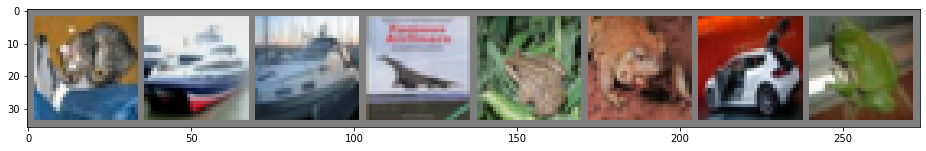

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 
Predicted:  cat   ship  ship  ship  deer  frog  car   frog 


In [13]:
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        logits = model(images)
        probabilities = F.softmax(logits, dim=1)
        _, predictions = torch.max(probabilities, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.9 %
Accuracy for class: car   is 74.6 %
Accuracy for class: bird  is 40.2 %
Accuracy for class: cat   is 33.5 %
Accuracy for class: deer  is 34.4 %
Accuracy for class: dog   is 58.1 %
Accuracy for class: frog  is 73.6 %
Accuracy for class: horse is 57.4 %
Accuracy for class: ship  is 83.5 %
Accuracy for class: truck is 59.5 %


# Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [2]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Take a look at [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for tips to train a model on GPU. 

Take a look at [here](https://github.com/kuangliu/pytorch-cifar) to see what somebig ConvNets did on CIFAR10 data.
